# Comparing SSA Instruments

**Goal**: Find colocated SSA measurements with more than one instrument and compare by plotting, this is replicating the plot found in the 
meta.pdf that came with the data

**Approach**:

1. Find all sites with SSA data 
2. Isolate the sites with multiple SSA instruments 
3. Plot each site with all its instruments we found



**Step 1**:

In [1]:
from snowxsql.db import get_db
from snowxsql.data import LayerData, PointData
from snowxsql.conversions import points_to_geopandas, query_to_geopandas

import geoalchemy2.functions as gfunc
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)

# Grab all the equivalent diameter profiles
ssa = session.query(LayerData).filter(LayerData.type == 'specific_surface_area').all()

# Grab all the sites with equivalent diameter data (set reduces a list to only its unique entries)
sites = set([d.site_id for d in ssa])

**Step 2**:

In [2]:
# Store all site names that have mulitple SSA instruments
multi_instr_sites = []
instruments = []
for site in sites:

    # Grab all the layers associated to this site
    site_data = [d for d in ssa if d.site_id == site]

    # Do a set on all the instruments used here
    instruments_used = set([d.instrument for d in site_data])

    if len(instruments_used) > 1:
        multi_instr_sites.append(site)
        instruments += instruments_used

# Get a unqique list of SSA instruments that were colocated
instruments = set(instruments)

**Step 3**:

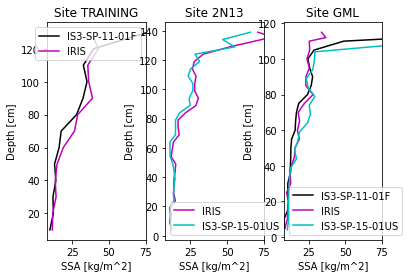

In [3]:
# Setup the subplot for each site for each instrument
fig, axes = plt.subplots(1, len(multi_instr_sites))
c = ['k', 'm', 'c']
colors = {inst:c[i] for i,inst in enumerate(instruments)}

for i, site in enumerate(multi_instr_sites):
    ax = axes[i]

    for instr in instruments:

        # Grab our profile
        data = [d for d in ssa if d.site_id==site and d.instrument==instr]
        depths = [d.depth for d in data]
        values = [float(d.value) for d in data]

        # Don't plot it unless there is data
        if values:
            df = pd.DataFrame({'depth':depths, 'SSA':values})
            df = df.set_index('depth')

            # Sort the index so samples that are take out of order won't mess up the plot
            df.sort_index()
            ax.plot(df['SSA'], df.index, colors[instr], label=instr)

    ax.legend()
    ax.set_xlabel('SSA [kg/m^2]')
    ax.set_ylabel('Depth [cm]')
    ax.set_title('Site {}'.format(site.upper()))
    ax.set_xlim((8, 75))
    
plt.show()

In [4]:
session.close()
